In [2]:
import xarray as xr
import numpy as np
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from xarray import DataArray
import pandas as pd
# from PyEMD import EEMD
import pylab as plt

In [6]:
data       = xr.open_dataset("/work/uo1075/u241321/data/u241321/data_cdo/transport_iceland_faroe_upper310_wt/ifc_heat_transport_1970_2019_gr15_velocitycom.nc") 
data1       = xr.open_dataset("/work/uo1075/u241321/data/u241321/data_cdo/transport_iceland_faroe_upper310_wt/ifc_heat_transport_1970_2019_gr15_tempcom.nc") 
data2       = xr.open_dataset("/work/uo1075/u241321/data/u241321/data_cdo/transport_iceland_faroe_upper310_wt/ifc_heat_transport_1970_2019_gr15_eddcom.nc") 

vel = data['heat_transport'][:,0,0]
temp = data1['heat_transport'][:,0,0]
edd = data2['heat_transport'][:,0,0]
sum_ = vel+temp+edd

data3       = xr.open_dataset("/work/uo1075/u241321/data/u241321/data_cdo/transport_FSC_upper310_assi/fsc_heat_transport_1970_2019_gr15_velocitycom.nc") 
data4       = xr.open_dataset("/work/uo1075/u241321/data/u241321/data_cdo/transport_FSC_upper310_assi/fsc_heat_transport_1970_2019_gr15_tempcom.nc") 
data5       = xr.open_dataset("/work/uo1075/u241321/data/u241321/data_cdo/transport_FSC_upper310_assi/fsc_heat_transport_1970_2019_gr15_eddcom.nc") 

vel1 = data3['heat_transport'][:,0,0]
temp1 = data4['heat_transport'][:,0,0]
edd1 = data5['heat_transport'][:,0,0]
sum_1 = vel1+temp1+edd1

y = sum_ + sum_1



In [9]:
# data       = xr.open_dataset("/work/uo1075/u241321/data/temperature_1965-2020_assi_dt_5000.nc") 
# lat_min, lat_max = (60,76) # Norwegian Sea
# lon_min, lon_max = (0,20)

# var11 = data['__xarray_dataarray_variable__'].sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
# var1 = np.mean(np.mean(var11, axis=1)[:,0:15,:,:],1)

# # weight average 
# weights = np.cos(np.deg2rad(var1.lat))
# weights.name = "weights"
# air_weighted = var1.weighted(weights)
# y1 = air_weighted.mean(("lon", "lat"))
# # y = y.assign_coords(time=yy.coords['time'])
# hcutyear = 3
# lcutyear = 10
# window = 5
# y315 = band_pass(y1, window, hcutyear, lcutyear)
# # assi  = np.load("/work/uo1075/u241321/data/eemd_t310_assi_Norwegian.npy") # (5,50) mode(input, c1-c4), time
# # c2= assi[2,:]
# y315[5:55]

<xarray.DataArray (time: 50)>
array([ 0.03274816, -0.01145055,  0.14166321,  0.23227165,  0.20121303,
        0.13869817,  0.05332492, -0.02004166, -0.10106614, -0.14234659,
       -0.09417866, -0.15541404, -0.12490658, -0.03716715, -0.00322262,
       -0.01173321, -0.15041499, -0.24025739, -0.18496482,  0.00134075,
        0.16644751,  0.07456818, -0.00752581, -0.05106412, -0.10947368,
       -0.0746513 , -0.18473352, -0.26240824, -0.00556877,  0.15196882,
       -0.0191094 , -0.07747086,  0.01254859,  0.09156726,  0.13666646,
        0.08683742,  0.12599093,  0.090303  ,  0.07637676,  0.08420326,
       -0.06992264, -0.13380034, -0.0584765 , -0.0196184 , -0.00424489,
        0.06694799,  0.22577117,  0.20611193,  0.0312597 ,         nan])
Coordinates:
  * time     (time) datetime64[ns] 1970-07-16T11:15:00 ... 2019-07-16T11:15:00

In [3]:
"""
Applying a bandpass filter
(the difference of two lowpass lanczos filters)
to a time-series.
==================================
This example demonstrates low pass filtering a time-series by applying a
weighted running mean over the time dimension.
The time-series used here is the EAR5 Reanalysis hourly 850hpa vorticity,
which is first averaged to daily data, and then filtered using two different
Lanczos filters, one to filter out time-scales of less than 3 years and one
to filter out time-scales of less than 10 years.
References
----------
    Duchon C. E. (1979) Lanczos Filtering in One and Two Dimensions.
    Journal of Applied Meteorology, Vol 18, pp 1016-1022.
"""

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, savefig
import matplotlib.colors
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER



def low_pass_weights(window, cutoff):
    """Calculate weights for a low pass Lanczos filter.
    Args:
    window: int
        The length of the filter window.
    cutoff: float
        The cutoff frequency in inverse time steps.
    """
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]

def band_pass(ts, window, hcutyear, lcutyear):
    window = window
    hfw = low_pass_weights(window, 1. / hcutyear)
    lfw = low_pass_weights(window, 1. / lcutyear)
    weight_high = xr.DataArray(hfw, dims = ['window'])
    weight_low = xr.DataArray(lfw, dims = ['window'])
    daily_data = ts

    # apply the filters using the rolling method with the weights
    lowpass_hf = daily_data.rolling(time = len(hfw), center = True).construct('window').dot(weight_high)
    lowpass_lf = daily_data.rolling(time = len(lfw), center = True).construct('window').dot(weight_low)

    # the bandpass is the difference of two lowpass filters.
    bandpass = lowpass_hf - lowpass_lf

    return bandpass

In [16]:
hcutyear = 3
lcutyear = 10
window = 5
y310 = band_pass(y, window, hcutyear, lcutyear)
y310[2:48]

<xarray.DataArray (time: 46)>
array([ 0.00738383, -0.00469773, -0.00946627, -0.00402007,  0.00711248,
       -0.00390873, -0.0084447 , -0.01505255, -0.01840301, -0.00335217,
        0.00542127,  0.00351293,  0.0065394 , -0.00753823, -0.01624924,
       -0.0230572 , -0.00974131,  0.0157765 ,  0.01050032, -0.00381307,
        0.00262858,  0.00364897, -0.00063965,  0.00337154,  0.00042013,
        0.00893061,  0.01572925,  0.00804415, -0.01016445, -0.01675621,
        0.00669924,  0.00862058, -0.01004768, -0.00545463,  0.01416815,
        0.01292069,  0.02465964,  0.02323217, -0.00987192, -0.01012212,
       -0.00749302, -0.00654194,  0.01519692,  0.01864856,  0.01631019,
        0.0174822 ])
Coordinates:
  * time     (time) datetime64[ns] 1972-07-16T11:15:00 ... 2017-07-16T11:15:00
    lon      float64 0.0
    lat      float64 0.0

In [18]:
# compare with previous EEMD one
trans_fsc = np.load("/work/uo1075/u241321/data/eemd_htransport310.npy")
trans_ifc = np.load("/work/uo1075/u241321/data/eemd_htransport310_ifc.npy")

assi = trans_fsc+trans_ifc
assi_eemd = assi[2,:]+assi[3,:]+assi[4,:]
np.corrcoef(y310[2:48], assi_eemd[2:48])

array([[1.        , 0.78154152],
       [0.78154152, 1.        ]])

In [19]:
np.save("/work/uo1075/u241321/data/y310_htransport", y310)

In [5]:
# for tendency of ocean heat content and heat flux:
y = np.load("/work/uo1075/u241321/data/slheat_budget_Norw_wt.npy")[0,:]   # tendency 
y_ts = xr.DataArray(y, dims = ['time'])
y_ts = y_ts.assign_coords(time=yy.coords['time'])
y310 = band_pass(y_ts, window, hcutyear, lcutyear)
assi = np.load("/work/uo1075/u241321/data/eemd_slheat_Norwegian_wt.npy")
assi_eemd = assi[2,:]+assi[3,:]+assi[4,:]
np.corrcoef(y310[2:48], assi_eemd[2:48])

NameError: name 'yy' is not defined

In [6]:
np.save("/work/uo1075/u241321/data/y310_T", y310)
np.save("/work/uo1075/u241321/data/y315_T", y315)
np.save("/work/uo1075/u241321/data/y320_T", y320)
np.save("/work/uo1075/u241321/data/y330_T", y330)

In [7]:
y320[:49]

<xarray.DataArray (time: 49)>
array([ 0.06399351,  0.0430497 ,  0.22923121,  0.34643666,  0.31425888,
        0.22251458,  0.09328368, -0.02801484, -0.14914903, -0.2154681 ,
       -0.17911518, -0.24034205, -0.19843436, -0.09223755, -0.04887072,
       -0.07158627, -0.23767277, -0.3406107 , -0.25992118, -0.0209872 ,
        0.1841324 ,  0.09607529, -0.01134788, -0.08625492, -0.16997568,
       -0.15837125, -0.28272168, -0.34536771, -0.04523191,  0.14839157,
       -0.01572775, -0.0746843 ,  0.03379241,  0.141225  ,  0.20566423,
        0.1630991 ,  0.1996712 ,  0.15548513,  0.12489345,  0.10326361,
       -0.0848359 , -0.16969706, -0.09017444, -0.02954249,  0.01677813,
        0.12583843,  0.31056264,  0.2814549 ,  0.061584  ])
Coordinates:
  * time     (time) datetime64[ns] 1970-07-16T11:15:00 ... 2018-07-16T11:15:00

array([[1.        , 0.78097137],
       [0.78097137, 1.        ]])

In [9]:
np.corrcoef(c2[:49], y330[:49])

array([[1.        , 0.76032127],
       [0.76032127, 1.        ]])

In [10]:
np.corrcoef(c2[:49], y320[:49])

array([[1.        , 0.77057508],
       [0.77057508, 1.        ]])

In [11]:
np.corrcoef(c2[:49], y310[:49])

array([[1.        , 0.79937414],
       [0.79937414, 1.        ]])

/tmp/ipykernel_905264/3793037508.py:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(x, y310, '-', linestyle='dashed', color='black', linewidth=3, markersize=10, label = '3-10 yr')


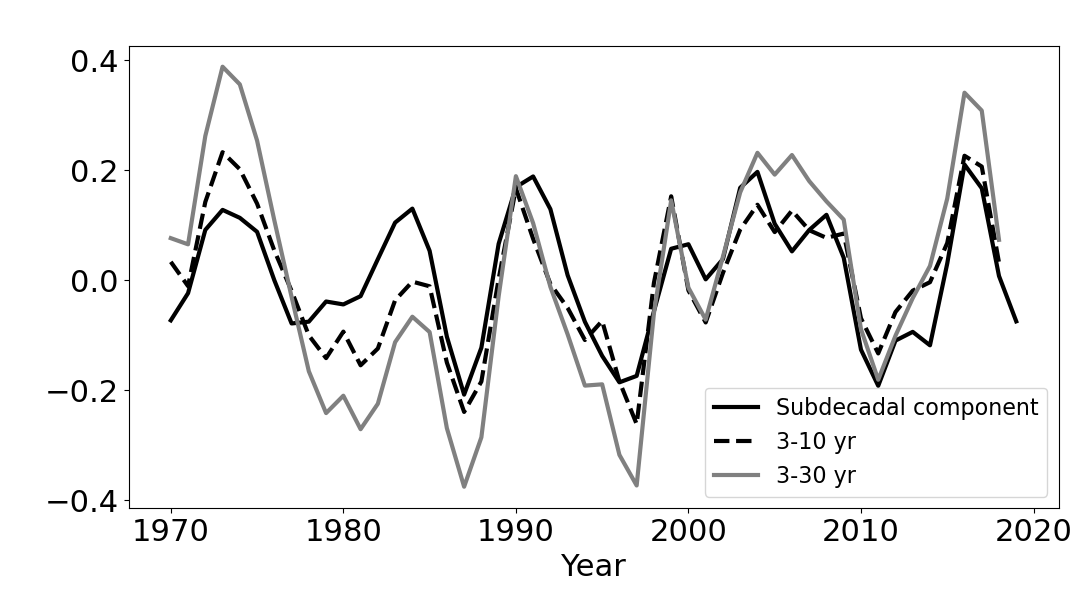

In [25]:
# Bandpass for T
x = np.arange(1970,2020,1)

fig, ax = plt.subplots(figsize = [12,6])
ax.plot(x, c2, '-', color='black', linewidth=3, markersize=10, label = 'Subdecadal component')
ax.plot(x, y310, '-', linestyle='dashed', color='black', linewidth=3, markersize=10, label = '3-10 yr')
ax.plot(x, y330, '-', color='gray', linewidth=3, markersize=10, label = '3-30 yr')
# ax.plot(x, y6, '-', color='orangered', linewidth=3, markersize=10, label = 'medium_spg')


# ax.axhline(0.277, linewidth=2, color='black', linestyle= 'dashed')
ax.set(xlabel='Year', ylabel=' ',
       title=' ')
# ax.set_ylim(-0.1, 1.1)
# ax.grid()
ax.legend(loc='lower right', fontsize='16')
# ax.annotate('5%', fontsize='16',
#             xy=(80, 150), xycoords='figure points')

plt.rcParams["font.size"] = "22"
plt.show()
fig.savefig('/work/uo1075/u241321/results/bandpass_ts.pdf',bbox_inches='tight')    

/tmp/ipykernel_666845/1299507131.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(x, y330, '-', linestyle='dashed', color='green', linewidth=3, markersize=10, label = '3-30 yr')
/tmp/ipykernel_666845/1299507131.py:13: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(x, y310, '-', linestyle='dashed', color='blue', linewidth=3, markersize=10, label = '3-10 yr')
/tmp/ipykernel_666845/1299507131.py:14: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(x, y315, '-', linestyle='dashed', color='orangered', linewidth=3, markersize=10, label = '3-15 yr')
/tmp/ipykernel_666845/1299507131.py:15: UserWarning: li

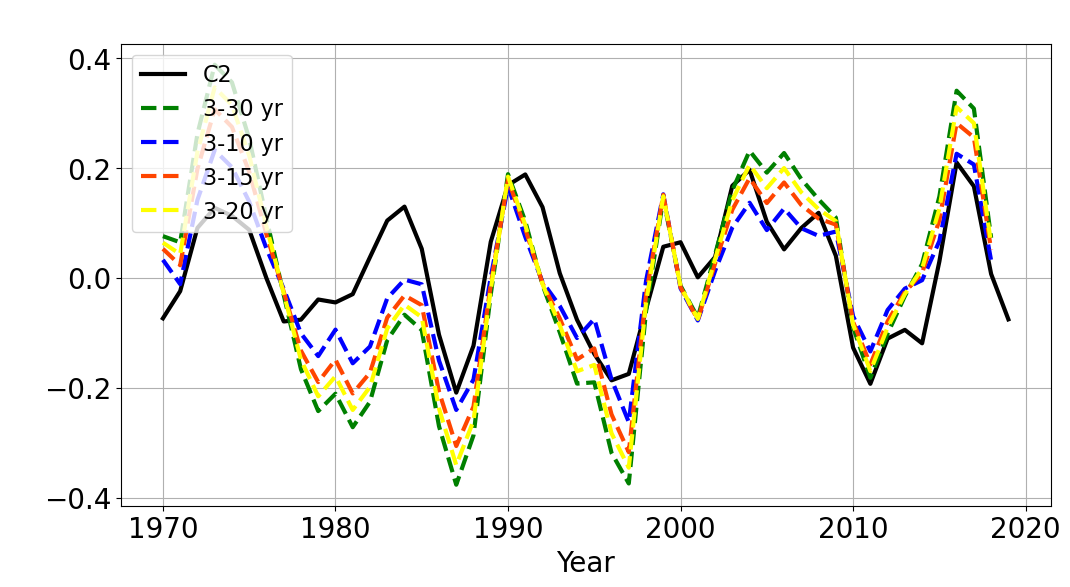

In [103]:
# Bandpass for T
x = np.arange(1970,2020,1)

fig, ax = plt.subplots(figsize = [12,6])
ax.plot(x, c2, '-', color='black', linewidth=3, markersize=10, label = 'C2')
ax.plot(x, y330, '-', linestyle='dashed', color='green', linewidth=3, markersize=10, label = '3-30 yr')
ax.plot(x, y310, '-', linestyle='dashed', color='blue', linewidth=3, markersize=10, label = '3-10 yr')
ax.plot(x, y315, '-', linestyle='dashed', color='orangered', linewidth=3, markersize=10, label = '3-15 yr')
ax.plot(x, y320, '-', linestyle='dashed', color='yellow', linewidth=3, markersize=10, label = '3-20 yr')
# ax.plot(x, y6, '-', color='orangered', linewidth=3, markersize=10, label = 'medium_spg')


# ax.axhline(0.277, linewidth=2, color='black', linestyle= 'dashed')
ax.set(xlabel='Year', ylabel=' ',
       title=' ')
# ax.set_ylim(-0.1, 1.1)
ax.grid()
ax.legend(loc='upper left', fontsize='16')
# ax.annotate('5%', fontsize='16',
#             xy=(80, 150), xycoords='figure points')

plt.rcParams["font.size"] = "20"
plt.show()
# fig.savefig('/work/uo1075/u241321/results/EEMD_ACC_sst.pdf')

In [1]:
# Bandpass for NAO and SPG
na = np.load("/work/uo1075/u241321/data/eemd_NAO_DJF_dt.npy")   # linealy detrened for each grid point  
nao = na[0,:]
nao_ts = xr.DataArray(nao, dims = ['time'])
nao_ts = data_series.assign_coords(time=yy.coords['time'])

spg1 = np.load("/work/uo1075/u241321/data/EEMD_spg_density_dt.npy")   # (5,50) mode(input, c1-c4), time
spg = spg1[0,:]
spg_ts = xr.DataArray(spg, dims = ['time'])
spg_ts = spg_ts.assign_coords(time=yy.coords['time'])

NameError: name 'np' is not defined

In [121]:
hcutyear = 3
lcutyear = 30
window = 5
nao_330 = band_pass(nao_ts, window, hcutyear, lcutyear)
nao_330

<xarray.DataArray (time: 50)>
array([        nan,         nan,  0.06908333,  0.10636   ,  0.09732042,
        0.06784138, -0.00209571, -0.06491191, -0.06239092, -0.03541782,
       -0.03556052, -0.02442619,  0.02838613,  0.0895091 ,  0.11044498,
        0.04500761, -0.08953989, -0.17444466, -0.10432552,  0.04885966,
        0.14468821,  0.158175  ,  0.103482  ,  0.00991241, -0.06345415,
       -0.11456932, -0.15489982, -0.14016341, -0.04456585,  0.04981647,
        0.05044811, -0.00046033,  0.02996128,  0.13244816,  0.15704787,
        0.08262307,  0.03810455,  0.07193453,  0.09994564,  0.03117168,
       -0.10323941, -0.15220763, -0.09547357, -0.08288077, -0.09100155,
        0.02752803,  0.16925719,  0.14134566,         nan,         nan])
Coordinates:
  * time     (time) datetime64[ns] 1970-07-16T11:15:00 ... 2019-07-16T11:15:00

In [134]:
# for NAO
hcutyear = 3
lcutyear = 30
window = 5
nao_330 = band_pass(nao_ts, window, hcutyear, lcutyear)
hcutyear = 3
lcutyear = 10
window = 5
nao_310 = band_pass(nao_ts, window, hcutyear, lcutyear)
hcutyear = 3
lcutyear = 15
window = 5
nao_315 = band_pass(nao_ts, window, hcutyear, lcutyear)
hcutyear = 3
lcutyear = 20
window = 5
nao_320 = band_pass(nao_ts, window, hcutyear, lcutyear)

# for SPG
hcutyear = 3
lcutyear = 30
window = 5
spg_330 = band_pass(spg_ts, window, hcutyear, lcutyear)
hcutyear = 3
lcutyear = 10
window = 5
spg_310 = band_pass(spg_ts, window, hcutyear, lcutyear)
hcutyear = 3
lcutyear = 15
window = 5
spg_315 = band_pass(spg_ts, window, hcutyear, lcutyear)
hcutyear = 3
lcutyear = 20
window = 5
spg_320 = band_pass(spg_ts, window, hcutyear, lcutyear)

In [125]:
# lead-lag correlation
from scipy.stats import pearsonr
import numpy as np

# lead lag pearson correlation, negative values indicate data1 leads data2, n is the lead lag step
# the time length for correlation is sample-n; for example, for 50 years sample,
# if 10 yrs leadlag is choosen, the time length is 40 yrs

def leadlagcor(data1,data2,n):
    a=-n
    b=-a
    c=b*2+1
    x=np.arange(-n,n+1,1)
    r=np.zeros((c,1))
    p=np.zeros((c,1))
    begin=x[c-1]
    end=len(data1)-x[c-1]
    
    for i in range(c):
        if i<=(b):
            r[n-i],p[n-i]=pearsonr(data1[:end], data2[i:end+i])
        else:
            r[i],p[i]=pearsonr(data1[x[i]:end+x[i]], data2[:end])
    return r,p

/tmp/ipykernel_666845/2585506825.py:22: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(x, y2, '-', color='orangered',linestyle='dashed',linewidth=3.6, markersize=10, label = 'T&SPG', zorder=10)


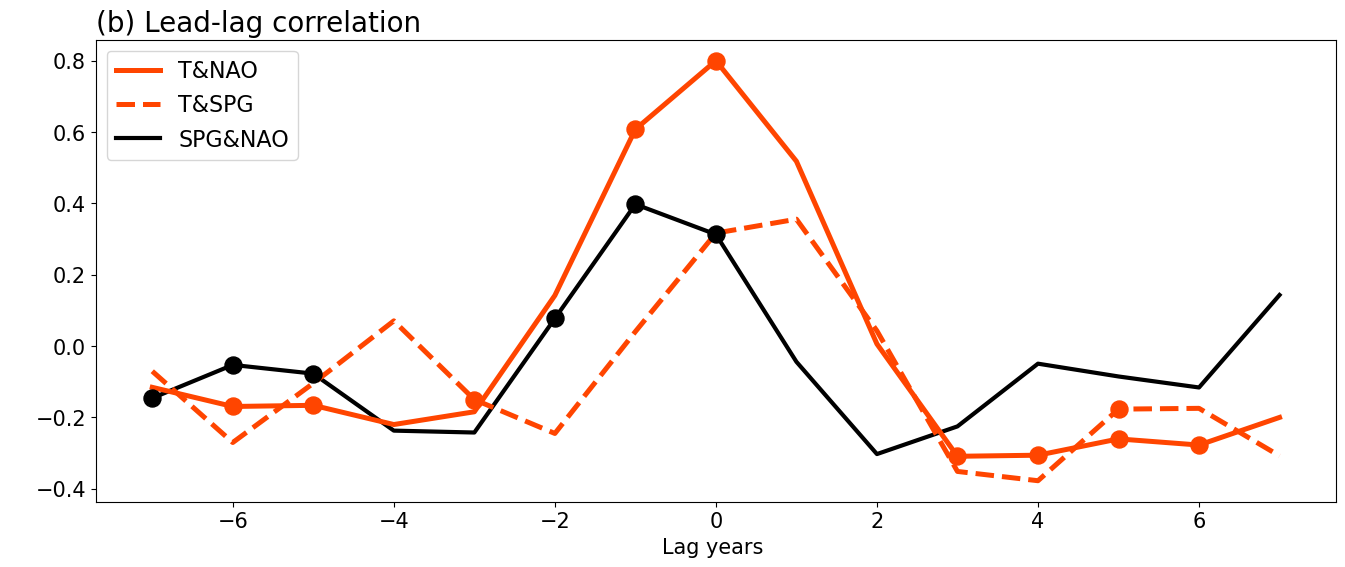

In [137]:
# 310

n=7

corr, sig=leadlagcor(nao_310[2:48],y310[2:48],n)
corr1, sig1=leadlagcor(spg_310[2:48],y310[2:48],n)
corr2, sig2=leadlagcor(nao_310[2:48],spg_310[2:48],n)

# 
dotsize = 150
color = 'orangered'     
x = np.arange(-n,n+1)
y1 = corr[:,0]
y2 = corr1[:,0]
y3 = corr2[:,0]
# y4 = corr[3,:]


fig, ax = plt.subplots(figsize = [16,6])

ax.plot(x, y1, '-', color='orangered', linewidth=3.6, markersize=10, label = 'T&NAO', zorder=10)
ax.plot(x, y2, '-', color='orangered',linestyle='dashed',linewidth=3.6, markersize=10, label = 'T&SPG', zorder=10)
ax.plot(x, y3, '-', linewidth=3, color='black',markersize=10, label = 'SPG&NAO')

# ax.scatter(x, y1, 'o-', s=[1,2,3,2,4,3,2,2,2,1], linestyle='dashed', color='blue',label = 'raw_dtrend')
# ax.scatter(x, y1,  marksize3,color='orangered')
# ax.scatter(x, y2,  marksize1,color='green')

# NAO & T
ax.scatter(x[1], y1[1], dotsize,color=color, zorder=10)
ax.scatter(x[2], y1[2], dotsize,color=color, zorder=10)
ax.scatter(x[6], y1[6], dotsize,color=color, zorder=10)
ax.scatter(x[7], y1[7], dotsize,color=color, zorder=10)
ax.scatter(x[10], y1[10], dotsize,color=color, zorder=10)
ax.scatter(x[11], y1[11], dotsize,color=color, zorder=10)
ax.scatter(x[12], y1[12], dotsize,color=color, zorder=10)
ax.scatter(x[13], y1[13], dotsize,color=color, zorder=10)

# SPG & T
color = 'orangered'     
ax.scatter(x[4], y2[4], dotsize,color=color, zorder=10)
ax.scatter(x[12], y2[12], dotsize,color=color, zorder=10)

# NAO & SPG
color = 'black'     
ax.scatter(x[1], y3[1], dotsize,color=color, zorder=10)
ax.scatter(x[2], y3[2], dotsize,color=color, zorder=10)
ax.scatter(x[6], y3[6], dotsize,color=color, zorder=10)
ax.scatter(x[7], y3[7], dotsize,color=color, zorder=10)
ax.scatter(x[0], y3[0], dotsize,color=color, zorder=10)
ax.scatter(x[5], y3[5], dotsize,color=color, zorder=10)


ax.set_title('(b) Lead-lag correlation ',size = '20', loc = 'left', pad = 19)

ax.set(xlabel='Lag years ', ylabel=' ',
       title='')
# ax.set_ylim(-1, 0.8)
# ax.grid()
ax.legend(loc='upper left', fontsize='16')
# ax.annotate('5%', fontsize='16',
#             xy=(80, 150), xycoords='figure points')

plt.rcParams["font.size"] = "15"
plt.show()
# fig.savefig('/work/uo1075/u241321/results/c2_lead.pdf')    

/tmp/ipykernel_666845/3282336479.py:22: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(x, y2, '-', color='orangered',linestyle='dashed',linewidth=3.6, markersize=10, label = 'T&SPG', zorder=10)


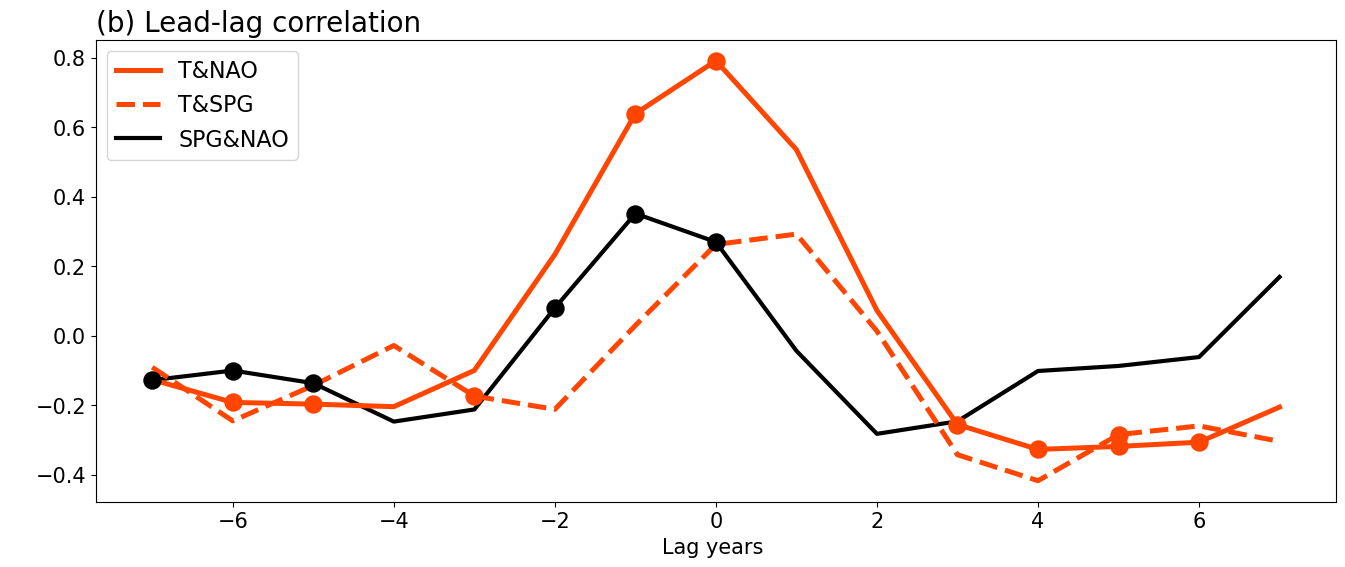

In [136]:
# 315

n=7

corr, sig=leadlagcor(nao_315[2:48],y315[2:48],n)
corr1, sig1=leadlagcor(spg_315[2:48],y315[2:48],n)
corr2, sig2=leadlagcor(nao_315[2:48],spg_315[2:48],n)

# 
dotsize = 150
color = 'orangered'     
x = np.arange(-n,n+1)
y1 = corr[:,0]
y2 = corr1[:,0]
y3 = corr2[:,0]
# y4 = corr[3,:]


fig, ax = plt.subplots(figsize = [16,6])

ax.plot(x, y1, '-', color='orangered', linewidth=3.6, markersize=10, label = 'T&NAO', zorder=10)
ax.plot(x, y2, '-', color='orangered',linestyle='dashed',linewidth=3.6, markersize=10, label = 'T&SPG', zorder=10)
ax.plot(x, y3, '-', linewidth=3, color='black',markersize=10, label = 'SPG&NAO')

# ax.scatter(x, y1, 'o-', s=[1,2,3,2,4,3,2,2,2,1], linestyle='dashed', color='blue',label = 'raw_dtrend')
# ax.scatter(x, y1,  marksize3,color='orangered')
# ax.scatter(x, y2,  marksize1,color='green')

# NAO & T
ax.scatter(x[1], y1[1], dotsize,color=color, zorder=10)
ax.scatter(x[2], y1[2], dotsize,color=color, zorder=10)
ax.scatter(x[6], y1[6], dotsize,color=color, zorder=10)
ax.scatter(x[7], y1[7], dotsize,color=color, zorder=10)
ax.scatter(x[10], y1[10], dotsize,color=color, zorder=10)
ax.scatter(x[11], y1[11], dotsize,color=color, zorder=10)
ax.scatter(x[12], y1[12], dotsize,color=color, zorder=10)
ax.scatter(x[13], y1[13], dotsize,color=color, zorder=10)

# SPG & T
color = 'orangered'     
ax.scatter(x[4], y2[4], dotsize,color=color, zorder=10)
ax.scatter(x[12], y2[12], dotsize,color=color, zorder=10)

# NAO & SPG
color = 'black'     
ax.scatter(x[1], y3[1], dotsize,color=color, zorder=10)
ax.scatter(x[2], y3[2], dotsize,color=color, zorder=10)
ax.scatter(x[6], y3[6], dotsize,color=color, zorder=10)
ax.scatter(x[7], y3[7], dotsize,color=color, zorder=10)
ax.scatter(x[0], y3[0], dotsize,color=color, zorder=10)
ax.scatter(x[5], y3[5], dotsize,color=color, zorder=10)


ax.set_title('(b) Lead-lag correlation ',size = '20', loc = 'left', pad = 19)

ax.set(xlabel='Lag years ', ylabel=' ',
       title='')
# ax.set_ylim(-1, 0.8)
# ax.grid()
ax.legend(loc='upper left', fontsize='16')
# ax.annotate('5%', fontsize='16',
#             xy=(80, 150), xycoords='figure points')

plt.rcParams["font.size"] = "15"
plt.show()
# fig.savefig('/work/uo1075/u241321/results/c2_lead.pdf')    

/tmp/ipykernel_666845/2586828439.py:22: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(x, y2, '-', color='orangered',linestyle='dashed',linewidth=3.6, markersize=10, label = 'T&SPG', zorder=10)


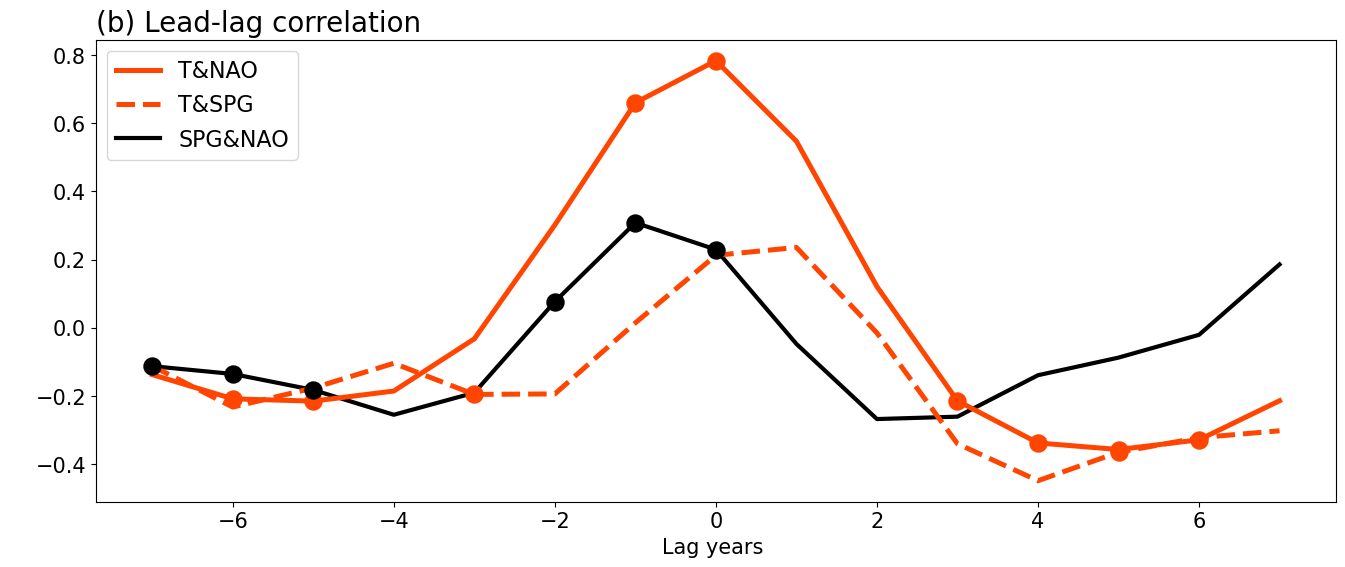

In [135]:
# 330

n=7

corr, sig=leadlagcor(nao_330[2:48],y330[2:48],n)
corr1, sig1=leadlagcor(spg_330[2:48],y330[2:48],n)
corr2, sig2=leadlagcor(nao_330[2:48],spg_330[2:48],n)

# 
dotsize = 150
color = 'orangered'     
x = np.arange(-n,n+1)
y1 = corr[:,0]
y2 = corr1[:,0]
y3 = corr2[:,0]
# y4 = corr[3,:]


fig, ax = plt.subplots(figsize = [16,6])

ax.plot(x, y1, '-', color='orangered', linewidth=3.6, markersize=10, label = 'T&NAO', zorder=10)
ax.plot(x, y2, '-', color='orangered',linestyle='dashed',linewidth=3.6, markersize=10, label = 'T&SPG', zorder=10)
ax.plot(x, y3, '-', linewidth=3, color='black',markersize=10, label = 'SPG&NAO')

# ax.scatter(x, y1, 'o-', s=[1,2,3,2,4,3,2,2,2,1], linestyle='dashed', color='blue',label = 'raw_dtrend')
# ax.scatter(x, y1,  marksize3,color='orangered')
# ax.scatter(x, y2,  marksize1,color='green')

# NAO & T
ax.scatter(x[1], y1[1], dotsize,color=color, zorder=10)
ax.scatter(x[2], y1[2], dotsize,color=color, zorder=10)
ax.scatter(x[6], y1[6], dotsize,color=color, zorder=10)
ax.scatter(x[7], y1[7], dotsize,color=color, zorder=10)
ax.scatter(x[10], y1[10], dotsize,color=color, zorder=10)
ax.scatter(x[11], y1[11], dotsize,color=color, zorder=10)
ax.scatter(x[12], y1[12], dotsize,color=color, zorder=10)
ax.scatter(x[13], y1[13], dotsize,color=color, zorder=10)

# SPG & T
color = 'orangered'     
ax.scatter(x[4], y2[4], dotsize,color=color, zorder=10)
ax.scatter(x[12], y2[12], dotsize,color=color, zorder=10)

# NAO & SPG
color = 'black'     
ax.scatter(x[1], y3[1], dotsize,color=color, zorder=10)
ax.scatter(x[2], y3[2], dotsize,color=color, zorder=10)
ax.scatter(x[6], y3[6], dotsize,color=color, zorder=10)
ax.scatter(x[7], y3[7], dotsize,color=color, zorder=10)
ax.scatter(x[0], y3[0], dotsize,color=color, zorder=10)
ax.scatter(x[5], y3[5], dotsize,color=color, zorder=10)


ax.set_title('(b) Lead-lag correlation ',size = '20', loc = 'left', pad = 19)

ax.set(xlabel='Lag years ', ylabel=' ',
       title='')
# ax.set_ylim(-1, 0.8)
# ax.grid()
ax.legend(loc='upper left', fontsize='16')
# ax.annotate('5%', fontsize='16',
#             xy=(80, 150), xycoords='figure points')

plt.rcParams["font.size"] = "15"
plt.show()
fig.savefig('/work/uo1075/u241321/results/c2_lead.pdf')    

In [107]:
# Fourier analysis

def periods(ts):
    from scipy import signal
    lenth = len(ts)
    f, psd = signal.periodogram(ts[1:lenth],detrend=False)
    per=1/f
    max3=np.zeros((3))
    psdc=psd.copy()

    # Get the 3 larges periods
    for i in range(3):
        max3[i]=per[psdc==max(psdc)]
        psdc[psdc==max(psdc)]=0

    # Generate rednoise with first order autoregression model AR(1)
    # it equals to persistence forecast based on 1 year lag
    from sklearn.linear_model import LinearRegression
    vv = ts.values
    y = vv[1:lenth].reshape(-1,1)
    x = vv[0:lenth-1].reshape(-1,1)
    reg = LinearRegression(fit_intercept=True).fit(x, y).coef_
    intercept = LinearRegression(fit_intercept=True).fit(x, y).intercept_
    rednoise = np.zeros((lenth-1))

    for i in range(0,lenth-1,1):
        rednoise[i] = reg[0,0]*vv[i] + intercept 

    # Chi-square statistical significancant test of spectrum compared with a red-noise time seies
    # Fourier analysis on Red noise
    from scipy.stats import chi2
    f_red, psd_red = signal.periodogram(rednoise,detrend=False)
    # chi2.ppf(0.05,30,)
    chi2 = chi2.ppf([0.99, 0.95, 0.9], 2) # 0.01, 0.05, 0.1 significant level, respectively
    ff = len(f)
    sign_amplitude = np.zeros((ff,3))
    sign_amplitude[:,0] = psd_red*chi2[0]/2
    sign_amplitude[:,1] = psd_red*chi2[1]/2
    sign_amplitude[:,2] = psd_red*chi2[2]/2
    plt.rcParams.update({'font.size': 24})
    plt.rcParams.update({'figure.figsize':(8,6)})
    fig = plt.figure(1,facecolor='white')
    # ax = fig.add_axes([0.05, 0.3, 0.8, 1.0])
    p1=plt.plot(f,psd,color ='darkblue')
    p2=plt.plot(f_red,psd_red,color = "red")
    p3=plt.plot(f,sign_amplitude,color = "green")
    # plt.xlim(0,0.03)
    #plt.ylim(1e-8,4e-5)
    plt.xlabel('Frequency (yr$^{-1}$)')
    plt.ylabel('Spectral density')    
    return f, psd, max3, psd_red, sign_amplitude

/tmp/ipykernel_666845/3946978162.py:7: RuntimeWarning: divide by zero encountered in divide
  per=1/f
/tmp/ipykernel_666845/3946978162.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  max3[i]=per[psdc==max(psdc)]
/tmp/ipykernel_666845/3946978162.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rednoise[i] = reg[0,0]*vv[i] + intercept


array([16.,  8., 48.])

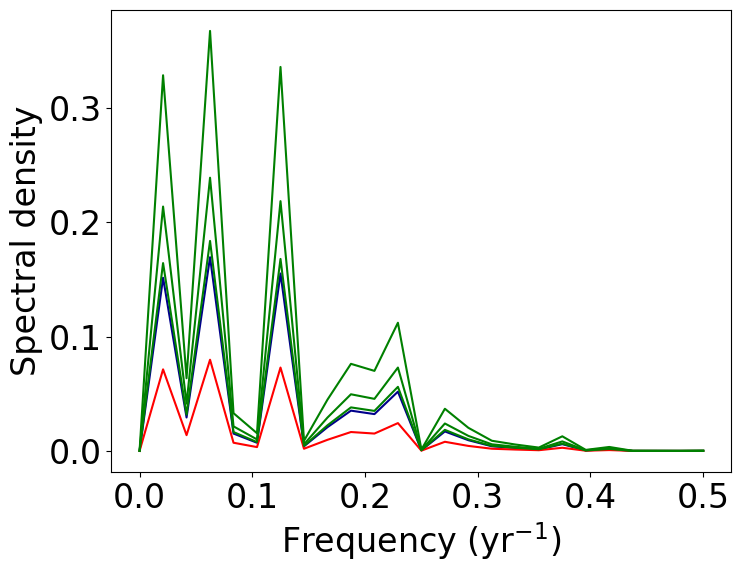

In [111]:
f, psd, max3, psd_red, sign_amplititude = periods(y310[:49])
max3